Data Loading and Preprocessing

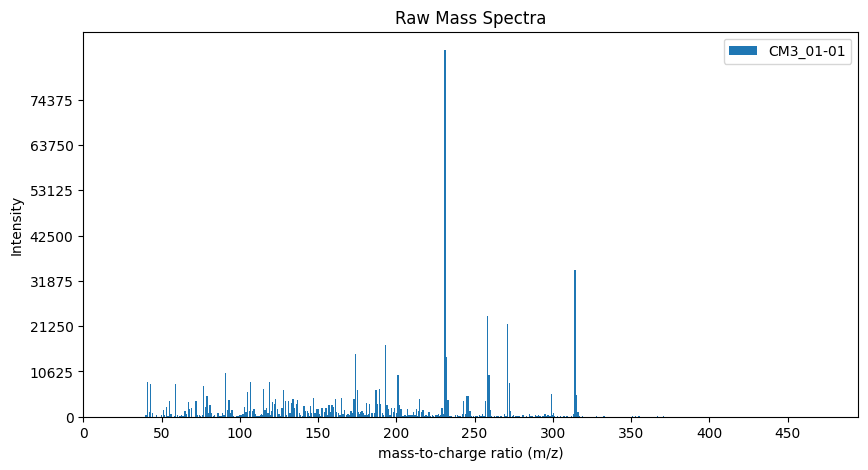

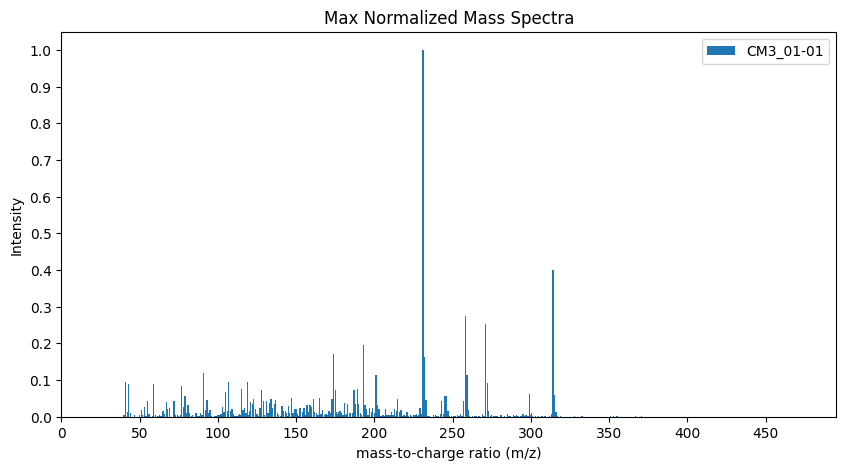

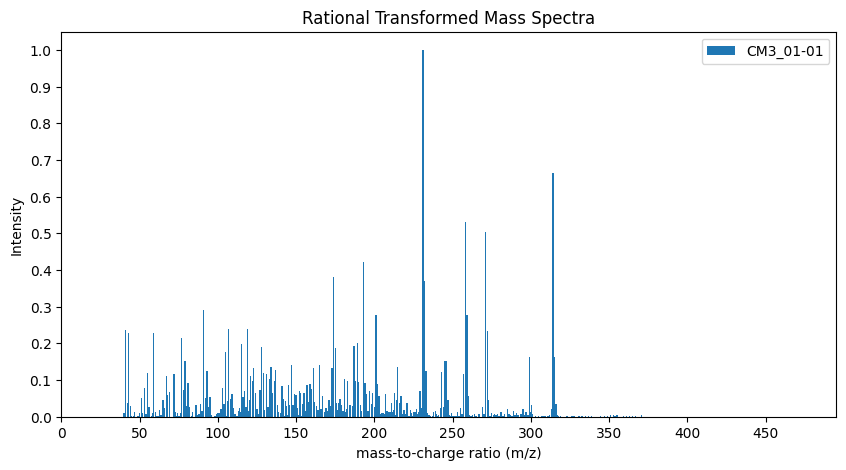

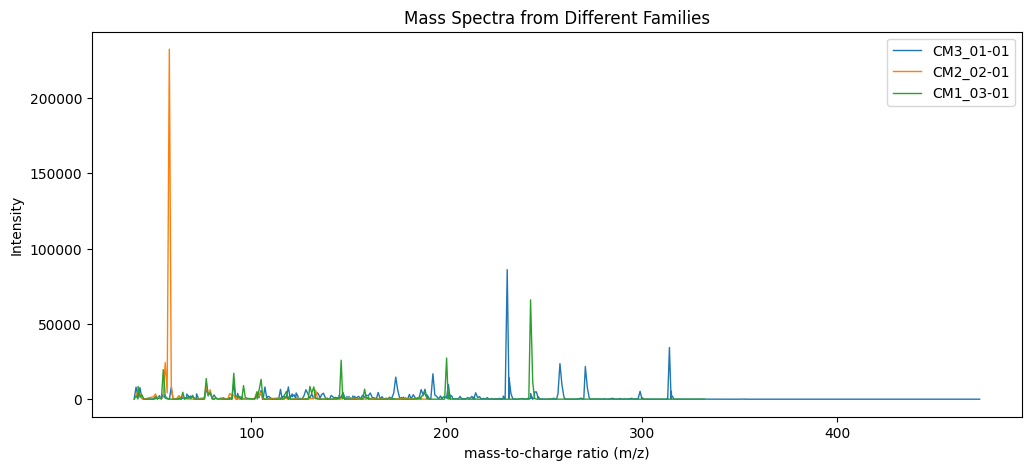

In [105]:
import pandas as pd
import numpy as np
from pathlib import Path
import glob
import matplotlib.pyplot as plt
import seaborn as sns
import copy

# Set color palette for families
family_palette = sns.color_palette("husl", 3)

def load_data(base_folders, num_files=None):
    """
    Load mass spectrometry data from multiple folders.

    Args:
        base_folders (list or str): List of folder paths or a single folder path.
        num_files (int, optional): Number of files to load from each folder. If None, all files will be loaded.

    Returns:
        dict: A dictionary of loaded data, where keys are file names and values are pandas DataFrames with 'Point' 'mz' and 'intensity' columns.
    """

    if isinstance(base_folders, str):
        base_folders = [base_folders]  # Convert single folder to list
    
    processed_data = {}

    for folder in base_folders:
        base_folder = Path(folder)
        file_pattern = base_folder / "*.csv"
        all_files = sorted(glob.glob(str(file_pattern)))

        if num_files is not None:
            all_files = all_files[:num_files]

        for file_path in all_files:
            file_name = f"{Path(folder).name}_{Path(file_path).stem}"  # Prefix filename with folder name
            df = pd.read_csv(file_path, skiprows=2, names=['Point', 'mz', 'intensity'])
            processed_data[file_name] = df

    return processed_data


raw_data = load_data(['CM1', 'CM2', 'CM3'])

# -------- Plot --------
selected_files = ['CM3_01-01', 'CM2_02-01', 'CM1_03-01']
plt.figure(1, figsize=(10, 5))
plt.bar(raw_data[selected_files[0]]['mz'], raw_data[selected_files[0]]['intensity'], label=selected_files[0])
plt.xlabel("mass-to-charge ratio (m/z)")
plt.ylabel("Intensity")
plt.xticks(np.arange(0, max(raw_data[selected_files[0]]['mz']) + 1, step=50))
plt.yticks(np.arange(0, 80000, step=((max(raw_data[selected_files[0]]['intensity']) // 1000) * 1000 // 8)))
plt.legend()
plt.title("Raw Mass Spectra")
# plt.grid(which='both', linestyle='--', linewidth=0.5)  # Optional: add grid lines
plt.show()
# -------- Plot --------

def normalize_spectra(data, method: str = 'max'):
    """
    Normalize mass spectrometry data.

    Args:
        data (dict): A dictionary of mass spectrometry data, where keys are file names and values are pandas DataFrames which includes 'mz', and 'intensity' columns.
        method (str): Normalization method ('max', 'sum', or 'zscore')

    Returns:
        dict: A dictionary of normalized data, same structure as input.
    """

    processed_data = copy.deepcopy(data)
    for file_name, df in data.items():
        intensities = df['intensity'].values
        if method == 'max':
            normalized = intensities / np.max(intensities)
        elif method == 'sum':
            normalized = intensities / np.sum(intensities)
        elif method == 'zscore':
            normalized = (intensities - np.mean(intensities)) / np.std(intensities)
            normalized = np.where(normalized < 0, 0, normalized)
        else:
            raise ValueError(f"Unknown normalization method: {method}")
            
        processed_data[file_name]['intensity'] = normalized
    return processed_data

normalized_data = normalize_spectra(raw_data)

# -------- Plot --------
plt.figure(2, figsize=(10, 5))
plt.bar(normalized_data[selected_files[0]]['mz'], normalized_data[selected_files[0]]['intensity'], label=selected_files[0])
plt.xlabel("mass-to-charge ratio (m/z)")
plt.ylabel("Intensity")
plt.xticks(np.arange(0, max(normalized_data[selected_files[0]]['mz']) + 1, step=50))
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.legend()
plt.title(f"Max Normalized Mass Spectra")
# plt.grid(which='both', linestyle='--', linewidth=0.5)  # Optional: add grid lines
plt.show()
# -------- Plot --------

def apply_rational_transform(data, upper_term: int = 3) -> None:
    """
    Apply rational transformation to intensity values using the formula:
    f(x) = ((upper_term)x)/((upper_term - 1)x + 1)

    Args:
        data (dict): A dictionary of mass spectrometry data, where keys are file names and values are pandas DataFrames which includes 'mz', and 'intensity' columns.
        upper_term (int): The upper term of the rational transformation.

    Returns:
        dict: A dictionary of transformed data, same structure as input.
    """

    processed_data = copy.deepcopy(data)

    for file_name, df in data.items():
        processed_df = df.copy()
        processed_df['intensity'] = (upper_term * df['intensity']) / (((upper_term - 1) * df['intensity']) + 1)
        processed_data[file_name] = processed_df
    return processed_data

transformed_data = apply_rational_transform(normalized_data)

# -------- Plot --------
plt.figure(3, figsize=(10, 5))
plt.bar(transformed_data[selected_files[0]]['mz'], transformed_data[selected_files[0]]['intensity'], label=selected_files[0])
plt.xlabel("mass-to-charge ratio (m/z)")
plt.ylabel("Intensity")
plt.xticks(np.arange(0, max(transformed_data[selected_files[0]]['mz']) + 1, step=50))
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.legend()
plt.title(f"Rational Transformed Mass Spectra")
# plt.grid(which='both', linestyle='--', linewidth=0.5)  # Optional: add grid lines
plt.show()
# -------- Plot --------

# -------- Combined Plot --------
plt.figure(4, figsize=(12, 5))
# sns.lineplot(x=raw_data[selected_files[0]]['mz'], y=raw_data[selected_files[0]]['intensity'], linewidth=1, label=selected_files[0])
# sns.lineplot(x=raw_data[selected_files[1]]['mz'], y=raw_data[selected_files[1]]['intensity'], linewidth=1, label=selected_files[1])
# sns.lineplot(x=raw_data[selected_files[2]]['mz'], y=raw_data[selected_files[2]]['intensity'], linewidth=1, label=selected_files[2])
plt.plot(raw_data[selected_files[0]]['mz'], raw_data[selected_files[0]]['intensity'], linewidth=1, label=selected_files[0])
plt.plot(raw_data[selected_files[1]]['mz'], raw_data[selected_files[1]]['intensity'], linewidth=1, label=selected_files[1])
plt.plot(raw_data[selected_files[2]]['mz'], raw_data[selected_files[2]]['intensity'], linewidth=1, label=selected_files[2])
plt.xlabel("mass-to-charge ratio (m/z)")
plt.ylabel("Intensity")
plt.legend()
plt.title(f"Mass Spectra from Different Families")
plt.show()

Data Binning

In [30]:
def bin_spectra(data_dict, mz_range=(39, 546), bin_width=1, aggregation='max'):
    """
    Bins the intensity values into fixed mz bins and aggregates using max or sum.
    
    Parameters:
        data_dict (dict): Dictionary where keys are filenames, values are DataFrames with 'mz' and 'intensity' columns.
        mz_range (tuple): (min_mz, max_mz) defining the range of mz values.
        bin_width (int): Width of each mz bin.
        aggregation (str): Aggregation method ('max' or 'sum').

    Returns:
        dict: Binned intensity vectors per file (pandas DataFrame).
    """

    # Define bin edges and bin centers
    bins = np.arange(mz_range[0], mz_range[1] + bin_width, bin_width)
    bin_centers = (bins[:-1] + bins[1:]) / 2  # Middle of each bin
    num_bins = len(bin_centers)
    binned_data = {}

    for filename, df in data_dict.items():
        # Assign each mz value to a bin
        df['bin'] = np.digitize(df['mz'], bins) - 1  # -1 to align with index
        df = df[(df['bin'] >= 0) & (df['bin'] < num_bins)]
        # Aggregate intensity per bin (max or sum)
        if aggregation == 'max':
            binned_intensities = df.groupby('bin')['intensity'].max()
        elif aggregation == 'sum':
            binned_intensities = df.groupby('bin')['intensity'].sum()
        else:
            raise ValueError("aggregation must be 'max' or 'sum'")

        intensity_vector = np.zeros(len(bin_centers))
        
        valid_bins = binned_intensities.index
        intensity_vector[valid_bins] = binned_intensities.values

        binned_data[filename] = intensity_vector

    # Convert to DataFrame (each row = file, each column = a bin)
    return pd.DataFrame.from_dict(binned_data, orient='index', columns=bin_centers)


# Get the min and max mz values
min_mz = int(min([df['mz'].min() for df in raw_data.values()]))
max_mz = int(max([df['mz'].max() for df in raw_data.values()]))
print(f"Min mz: {min_mz}, Max mz: {max_mz}")

binned_df = bin_spectra(data_dict=transformed_data, mz_range=(min_mz, max_mz), bin_width=1, aggregation='max')
binned_df.head()

# -------- Test --------

# data_dict = raw_data
# file_name = '01-02'

# fig, ax = plt.subplots(1, 2, figsize=(15, 5))
# ax[0].bar(data_dict[file_name]['mz'], data_dict[file_name]['intensity'])

# bin_centers = binned_df.columns.to_numpy()
# # print(binned_df.shape)
# ax[1].bar(bin_centers, binned_df.loc[file_name])
# plt.show()

# -------- Test --------

Min mz: 39, Max mz: 546


,39.5,40.5,41.5,42.5,43.5,44.5,45.5,46.5,47.5,48.5,...,536.5,537.5,538.5,539.5,540.5,541.5,542.5,543.5,544.5,545.5
CM1_01-01,0.0,0.011764,0.114915,0.436924,0.832152,0.154306,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CM1_01-02,0.0,0.014402,0.081302,0.454636,0.818123,0.156358,0.002585,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CM1_01-03,0.0,0.016366,0.122734,0.441392,0.813382,0.175307,0.000000,0.0,0.0,0.001954,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CM1_01-04,0.0,0.006322,0.135445,0.444746,0.807268,0.125592,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CM1_01-05,0.0,0.009724,0.104945,0.454967,0.829916,0.138316,0.004996,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Preparing data for Neural Network

In [31]:
# Create a function to extract the compound identifier
def get_compound_id(idx):
    return idx.rsplit('-', 1)[0]

binned_df['compound'] = [get_compound_id(idx) for idx in binned_df.index]

np.random.seed(3)
# Group by compound, then shuffle the groups
compounds = binned_df['compound'].unique()
np.random.shuffle(compounds)

shuffled_df = pd.concat([binned_df[binned_df['compound'] == comp] for comp in compounds])

# Drop the compound column so it doesn't interfere the training
shuffled_df.drop('compound', axis=1, inplace=True)

print(shuffled_df.shape)
print(shuffled_df.index)

(1350, 507)
Index(['CM1_16-01', 'CM1_16-02', 'CM1_16-03', 'CM1_16-04', 'CM1_16-05',
       'CM1_16-06', 'CM1_16-07', 'CM1_16-08', 'CM1_16-09', 'CM1_16-10',
       ...
       'CM3_21-01', 'CM3_21-02', 'CM3_21-03', 'CM3_21-04', 'CM3_21-05',
       'CM3_21-06', 'CM3_21-07', 'CM3_21-08', 'CM3_21-09', 'CM3_21-10'],
      dtype='object', length=1350)


In [32]:
# Split train-val-test compounds
split_train_val_test = [60, 20, 20]

if sum(split_train_val_test) != 100:
    raise ValueError("split_train_val_test must sum to 100")

# Get the number of compounds for each set
n_compounds_train = int((shuffled_df.shape[0] / 10) * split_train_val_test[0] / 100) * 10
n_compounds_val = int((shuffled_df.shape[0] / 10) * split_train_val_test[1] / 100) * 10

# Split the dataframe
train_compounds = shuffled_df[:n_compounds_train]
val_compounds = shuffled_df[n_compounds_train:(n_compounds_train + n_compounds_val)]
test_compounds = shuffled_df[(n_compounds_train + n_compounds_val):]

print(f"Train set size: {train_compounds.shape[0]} compounds")
print(f"Validation set size: {val_compounds.shape[0]} compounds")
print(f"Test set size: {test_compounds.shape[0]} compounds")


Train set size: 810 compounds
Validation set size: 270 compounds
Test set size: 270 compounds


In [33]:
import itertools
import random

def generate_pairs(binned_df_subset):
    compound_dict = {}
    for filename in binned_df_subset.index:  # ['01-01', '01-02', '01-03', ...]
        compound = filename.split('-')[0]  # ['01', '01', '01', ...]
        if compound not in compound_dict:
            compound_dict[compound] = []
        compound_dict[compound].append(filename)
    
    # compound_dict: {'01': ['01-01', '01-02', '01-03', ...], '02': ['02-01', '02-02', '02-03', ...], ...}

    pairs = []
    
    # Positive pairs (same compound)
    for compound, spectra in compound_dict.items():
        for s1, s2 in itertools.combinations(spectra, 2):  # All (S1, S2) pairs: (01-01, 01-02), (01-01, 01-03), ...
            pairs.append((binned_df_subset.loc[s1].values, binned_df_subset.loc[s2].values, 1))
    
    print(f'Number of positive pairs in subset: {len(pairs)}')

    # Negative pairs (different compounds)
    all_compounds = list(compound_dict.keys())
    negative_pairs = []

    for c1, c2 in itertools.combinations(all_compounds, 2):  # Pairs of different compounds: (01, 02), (01, 03), ...
        for s1 in compound_dict[c1]:
            for s2 in compound_dict[c2]:  # All (S1, S2) pairs: (01-01, 02-01), (01-01, 02-02), ...
                negative_pairs.append((binned_df_subset.loc[s1].values, binned_df_subset.loc[s2].values, 0))
    
    print(f'Number of negative pairs in subset: {len(negative_pairs)}')

    # Balance positive and negative pairs
    negative_sample_ratio = 1
    num_positive = len(pairs)
    num_negative = int(num_positive * negative_sample_ratio)
    sampled_negatives = random.sample(negative_pairs, min(num_negative, len(negative_pairs)))

    print(f'Number of sampled negative pairs in subset: {len(sampled_negatives)}')

    pairs.extend(sampled_negatives)
    random.shuffle(pairs)
    
    return pairs

# --------- Comment this part to save time in K-folds ---------

# Generate train, validation and test pairs separately
train_pairs = generate_pairs(train_compounds)
val_pairs = generate_pairs(val_compounds)
test_pairs = generate_pairs(test_compounds)

# Convert to NumPy arrays for neural network training
X1_train = np.array([p[0] for p in train_pairs], dtype=np.float32)  
X2_train = np.array([p[1] for p in train_pairs], dtype=np.float32)  
y_train = np.array([p[2] for p in train_pairs], dtype=np.float32)  

X1_val = np.array([p[0] for p in val_pairs], dtype=np.float32)  
X2_val = np.array([p[1] for p in val_pairs], dtype=np.float32)  
y_val = np.array([p[2] for p in val_pairs], dtype=np.float32)

# Prepare test pairs to evaluate model
X1_test = np.array([p[0] for p in test_pairs], dtype=np.float32)  
X2_test = np.array([p[1] for p in test_pairs], dtype=np.float32)  
y_test = np.array([p[2] for p in test_pairs], dtype=np.float32)

# Print dataset sizes
print(f"Train set size: {len(y_train)} pairs")
print(f"Validation set size: {len(y_val)} pairs")
print(f"Test set size: {len(y_test)} pairs")

Number of positive pairs in subset: 3645
Number of negative pairs in subset: 324000
Number of sampled negative pairs in subset: 3645
Number of positive pairs in subset: 1215
Number of negative pairs in subset: 35100
Number of sampled negative pairs in subset: 1215
Number of positive pairs in subset: 1215
Number of negative pairs in subset: 35100
Number of sampled negative pairs in subset: 1215
Train set size: 7290 pairs
Validation set size: 2430 pairs
Test set size: 2430 pairs


Training

In [34]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

# Setup device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define CNN + LSTM Embedding Function

# --- Comment to try only CNN embedding ---
def spectrum_embedding(x, cnn, lstm, fc):
# -----------------------------------------

# --- Add this to try only CNN embedding ---
# def spectrum_embedding(x, cnn, fc):
# -----------------------------------------

    x = x.unsqueeze(1)  # Add channel dimension
    x = cnn(x)  # Apply CNN

    # --- Add this to try only CNN embedding ---
    # x = x.mean(dim=2)  # Global average pooling to reduce dimensionality
    # -----------------------------------------

    # --- Comment to try only CNN embedding ---
    x = x.transpose(1, 2)  # Prepare for LSTM
    x, _ = lstm(x)  # Apply LSTM
    x = x[:, -1, :]  # Extract last hidden state
    # -----------------------------------------
    
    return fc(x)  # Pass through FC layers

# Create CNN + LSTM Layers
num_filters = 64
kernel_size = 8
padding = 2
use_pooling = True
pool_kernel = 2
# --- Comment to try only CNN embedding ---
lstm_hidden_size = 64
# -----------------------------------------
fc_hidden_units = [128, 64]

cnn = nn.Sequential(
    nn.Conv1d(1, num_filters, kernel_size, padding=padding),
    nn.ReLU(),
    nn.MaxPool1d(pool_kernel) if use_pooling else nn.Identity()
).to(device)

# --- Comment to try only CNN embedding ---
lstm = nn.LSTM(num_filters, lstm_hidden_size, batch_first=True).to(device)
# -----------------------------------------

fc_layers = []

# --- Add this to try only CNN embedding ---
# input_dim = num_filters  # Adjusted since LSTM is removed
# -----------------------------------------

# --- Comment to try only CNN embedding ---
input_dim = lstm_hidden_size
# -----------------------------------------

for units in fc_hidden_units:
    fc_layers.append(nn.Linear(input_dim, units))
    fc_layers.append(nn.ReLU())
    input_dim = units
fc = nn.Sequential(*fc_layers).to(device)

# Contrastive Loss Function
def contrastive_loss(distance, label, margin=1.0):
    return (label * distance**2 + (1 - label) * torch.clamp(margin - distance, min=0.0) ** 2).mean()

# Accuracy Calculation
def compute_accuracy(distances, labels, threshold=0.5):
    predictions = (distances < threshold).float()
    return (predictions == labels).float().mean().item()

# Dataset Class
class SpectrumDataset(Dataset):
    def __init__(self, X1, X2, labels):
        self.X1 = torch.tensor(X1, dtype=torch.float32)
        self.X2 = torch.tensor(X2, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.float32)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.X1[idx], self.X2[idx], self.labels[idx]

In [35]:
import torch.nn.functional as F
import time

# Training Loop
def train_siamese_network(train_loader, val_loader, num_epochs=10, lr=0.001, margin=1.0, patience=5):
    # --- Comment to try only CNN embedding ---
    optimizer = optim.Adam(list(cnn.parameters()) + list(lstm.parameters()) + list(fc.parameters()), lr=lr)
    # -----------------------------------------

    # --- Add this to try only CNN embedding ---
    # optimizer = optim.Adam(list(cnn.parameters()) + list(fc.parameters()), lr=lr)
    # -----------------------------------------

    best_val_loss = float("inf")
    best_model_state = None
    patience_counter = 0
    history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}

    print("Starting training...")
    for epoch in range(num_epochs):
        start_time = time.time()

        # --- Comment to try only CNN embedding ---
        cnn.train(), lstm.train(), fc.train()
        # -----------------------------------------

        # --- Add this to try only CNN embedding ---
        # cnn.train(), fc.train()
        # -----------------------------------------

        total_loss, total_acc = 0, 0

        for x1, x2, labels in train_loader:
            x1, x2, labels = x1.to(device), x2.to(device), labels.to(device)
            optimizer.zero_grad()

            # --- Comment to try only CNN embedding ---
            embed1 = spectrum_embedding(x1, cnn, lstm, fc)
            embed2 = spectrum_embedding(x2, cnn, lstm, fc)
            # -----------------------------------------

            # --- Add this to try only CNN embedding ---
            # embed1 = spectrum_embedding(x1, cnn, fc)
            # embed2 = spectrum_embedding(x2, cnn, fc)
            # -----------------------------------------

            distances = F.pairwise_distance(embed1, embed2, p=2)

            loss = contrastive_loss(distances, labels, margin)

            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            total_acc += compute_accuracy(distances, labels)

        avg_loss, avg_acc = total_loss / len(train_loader), total_acc / len(train_loader)
        history["train_loss"].append(avg_loss)
        history["train_acc"].append(avg_acc)

        # Validation
        # --- Comment to try only CNN embedding ---
        cnn.eval(), lstm.eval(), fc.eval()
        # -----------------------------------------

        # --- Add this to try only CNN embedding ---
        # cnn.eval(), fc.eval()
        # -----------------------------------------

        val_loss, val_acc = 0, 0
        with torch.no_grad():
            for x1, x2, labels in val_loader:
                x1, x2, labels = x1.to(device), x2.to(device), labels.to(device)

                # --- Comment to try only CNN embedding ---
                embed1 = spectrum_embedding(x1, cnn, lstm, fc)
                embed2 = spectrum_embedding(x2, cnn, lstm, fc)
                # -----------------------------------------

                # --- Add this to try only CNN embedding ---
                # embed1 = spectrum_embedding(x1, cnn, fc)
                # embed2 = spectrum_embedding(x2, cnn, fc)
                # -----------------------------------------

                distances = F.pairwise_distance(embed1, embed2, p=2)
                loss = contrastive_loss(distances, labels, margin)
                val_loss += loss.item()
                val_acc += compute_accuracy(distances, labels)

        avg_val_loss, avg_val_acc = val_loss / len(val_loader), val_acc / len(val_loader)
        history["val_loss"].append(avg_val_loss)
        history["val_acc"].append(avg_val_acc)

        # Early stopping check
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss

            # --- Comment to try only CNN embedding ---
            best_model_state = {"cnn": cnn.state_dict(), "lstm": lstm.state_dict(), "fc": fc.state_dict()}
            # -----------------------------------------

            # --- Add this to try only CNN embedding ---
            # best_model_state = {"cnn": cnn.state_dict(), "fc": fc.state_dict()}
            # -----------------------------------------

            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping triggered at epoch {epoch+1}.")
                break

        elapsed_time = time.time() - start_time
        remaining_time = elapsed_time * (num_epochs - epoch - 1)
        print(f"Epoch {epoch+1}: Train Loss={avg_loss:.4f}, Train Acc={avg_acc:.4f} - Val Loss={avg_val_loss:.4f}, Val Acc={avg_val_acc:.4f} - ETA: {remaining_time:.2f}s")
    
    if best_model_state:
        cnn.load_state_dict(best_model_state["cnn"])

        # --- Comment to try only CNN embedding ---
        lstm.load_state_dict(best_model_state["lstm"])
        # -----------------------------------------
        
        fc.load_state_dict(best_model_state["fc"])
        print("Best model loaded (lowest validation loss).")
    
    return history


In [36]:
# ------------------ K-FOLD CROSS VALIDATION TRAINING ------------------

# from sklearn.model_selection import KFold

# # Define K-Fold Cross-Validation
# K = 5
# kf = KFold(n_splits=K, shuffle=True, random_state=42)
# all_val_accuracies = []

# for fold, (train_idx, val_idx) in enumerate(kf.split(compounds)):
#     print(f"Fold {fold+1}/{K}")
    
#     train_compounds = compounds[train_idx]
#     val_compounds = compounds[val_idx]
    
#     train_df = binned_df[binned_df['compound'].isin(train_compounds)]
#     val_df = binned_df[binned_df['compound'].isin(val_compounds)]

#     train_df.drop('compound', axis=1, inplace=True)
#     val_df.drop('compound', axis=1, inplace=True)
    
#     # Generate train, validation and test pairs separately
#     train_pairs = generate_pairs(train_df)
#     val_pairs = generate_pairs(val_df)
  
#     # Convert to NumPy arrays for neural network training
#     X1_train = np.array([p[0] for p in train_pairs], dtype=np.float32)  
#     X2_train = np.array([p[1] for p in train_pairs], dtype=np.float32)  
#     y_train = np.array([p[2] for p in train_pairs], dtype=np.float32)  

#     X1_val = np.array([p[0] for p in val_pairs], dtype=np.float32)  
#     X2_val = np.array([p[1] for p in val_pairs], dtype=np.float32)  
#     y_val = np.array([p[2] for p in val_pairs], dtype=np.float32)
    
#     train_dataset = SpectrumDataset(X1_train, X2_train, y_train)
#     val_dataset = SpectrumDataset(X1_val, X2_val, y_val)
#     train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
#     val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
    
#     # Create CNN + LSTM Layers
#     num_filters = 64
#     kernel_size = 8
#     padding = 2
#     use_pooling = True
#     pool_kernel = 2
#     lstm_hidden_size = 64
#     fc_hidden_units = [128, 64]

#     cnn = nn.Sequential(
#         nn.Conv1d(1, num_filters, kernel_size, padding=padding),
#         nn.ReLU(),
#         nn.MaxPool1d(pool_kernel) if use_pooling else nn.Identity()
#     ).to(device)

#     lstm = nn.LSTM(num_filters, lstm_hidden_size, batch_first=True).to(device)

#     fc_layers = []
#     input_dim = lstm_hidden_size
#     for units in fc_hidden_units:
#         fc_layers.append(nn.Linear(input_dim, units))
#         fc_layers.append(nn.ReLU())
#         input_dim = units
#     fc = nn.Sequential(*fc_layers).to(device)
    
#     # Train the model on this fold
#     history = train_siamese_network(train_loader, val_loader, num_epochs=30, lr=0.001, margin=1, patience=10)
    
#     # Extract the best validation accuracy from history
#     best_val_acc = max(history["val_acc"])
#     all_val_accuracies.append(best_val_acc)
#     print(f"Fold {fold+1} Best Validation Accuracy: {best_val_acc:.4f}\n")

# # Compute overall validation performance
# print(f"Average Validation Accuracy: {np.mean(all_val_accuracies):.4f}")

# ------------------ RESULTS (run in the cloud to not melt my laptop) ------------------

# Fold 1 Best Validation Accuracy: 0.9572
# Fold 2 Best Validation Accuracy: 0.9700
# Fold 3 Best Validation Accuracy: 0.9670
# Fold 4 Best Validation Accuracy: 0.9749
# Fold 5 Best Validation Accuracy: 0.9424

# Average Validation Accuracy: 0.9623

In [ ]:
# Create Dataset instances
train_dataset = SpectrumDataset(X1_train, X2_train, y_train)
val_dataset = SpectrumDataset(X1_val, X2_val, y_val)
test_dataset = SpectrumDataset(X1_test, X2_test, y_test)

# Create DataLoaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Model Training
history = train_siamese_network(train_loader, val_loader, num_epochs=30, lr=0.001, margin=1.0, patience=10)

In [ ]:
# Plot Loss
plt.figure(figsize=(10, 5))
plt.plot(history["train_loss"], label="Train Loss")
plt.plot(history["val_loss"], label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.ylim(0, 1)  # Set y-axis range from 0 to 1
plt.yticks(np.arange(0, 1.1, 0.1))  # Set major ticks every 0.1
plt.minorticks_on()  # Enable minor ticks
plt.gca().yaxis.set_minor_locator(plt.MultipleLocator(0.05))  # Set minor ticks every 0.05
plt.legend()
plt.title("Training & Validation Loss")
plt.grid(which='both', linestyle='--', linewidth=0.5)  # Optional: add grid lines
plt.show()

# Plot Accuracy
plt.figure(figsize=(10, 5))
plt.plot(history["train_acc"], label="Train Accuracy")
plt.plot(history["val_acc"], label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.ylim(0, 1)  # Set y-axis range from 0 to 1
plt.yticks(np.arange(0, 1.1, 0.1))  # Set major ticks every 0.1
plt.minorticks_on()  # Enable minor ticks
plt.gca().yaxis.set_minor_locator(plt.MultipleLocator(0.05))  # Set minor ticks every 0.05
plt.legend()
plt.title("Training & Validation Accuracy")
plt.grid(which='both', linestyle='--', linewidth=0.5)  # Optional: add grid lines
plt.show()


Test the model on unseen data

In [39]:
import torch
import torch.nn.functional as F

# Save complete models (architecture + weights)

# torch.save(cnn_model, 'cnn_complete.pth')
# torch.save(lstm_model, 'lstm_complete.pth')
# torch.save(fc_model, 'fc_complete.pth')

# Load complete models
cnn = torch.load('cnn_complete.pth', weights_only=False)
lstm = torch.load('lstm_complete.pth', weights_only=False)
fc = torch.load('fc_complete.pth', weights_only=False)

In [40]:
# Test the model on unseen test data

# Ensure the model is in evaluation mode
cnn.eval(), lstm.eval(), fc.eval()

# Best Threshold after evaluation
threshold = 0.45

correct = 0
total = 0

# Evaluate on test set
with torch.no_grad():
    for x1, x2, labels in test_loader:
        x1, x2, labels = x1.to(device), x2.to(device), labels.to(device)
        
        embed1 = spectrum_embedding(x1, cnn, lstm, fc)
        embed2 = spectrum_embedding(x2, cnn, lstm, fc)
        distances = F.pairwise_distance(embed1, embed2, p=2)

        predictions = (distances < threshold).float()

        correct += (predictions == labels).sum().item()
        total += len(labels)

test_accuracy = correct / total
print(f"Test Accuracy: {test_accuracy:.4f} ({correct}/{total} correct)")


Test Accuracy: 0.9844 (2392/2430 correct)


Threshold Calibration

In [41]:
import seaborn as sns

# Ensure the model is in evaluation mode
cnn.eval(), lstm.eval(), fc.eval()

same_distances = []
different_distances = []

# Evaluate on validation set
with torch.no_grad():
    for x1, x2, labels in val_loader:
    # for x1, x2, labels in train_loader:
        x1, x2, labels = x1.to(device), x2.to(device), labels.to(device)
        
        embed1 = spectrum_embedding(x1, cnn, lstm, fc)
        embed2 = spectrum_embedding(x2, cnn, lstm, fc)
        distances = F.pairwise_distance(embed1, embed2, p=2)

        for i, label in enumerate(labels):
            if label == 1:
                same_distances.append(distances[i].item())
            else:
                different_distances.append(distances[i].item())


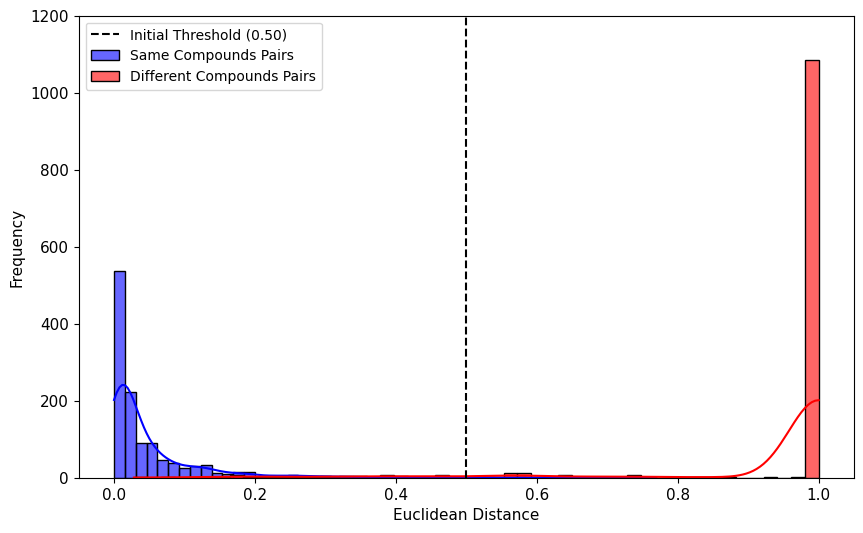

In [68]:
# Plot the distance distributions

same_distances = np.array(same_distances)
different_distances = np.array(different_distances)

# Clip negative distances greater than 1 for visualization
different_distances = np.clip(different_distances, 0, 1)
same_distances = np.clip(same_distances, 0, 1)

# Plot distributions
plt.figure(figsize=(10, 6))
sns.histplot(same_distances, bins=50, kde=True, label="Same Compounds Pairs", color="blue", alpha=0.6)
sns.histplot(different_distances, bins=50, kde=True, label="Different Compounds Pairs", color="red", alpha=0.6)
plt.axvline(x=0.50, color='black', linestyle='dashed', label="Initial Threshold (0.50)")
plt.xlabel("Euclidean Distance", fontsize=11)
plt.ylabel("Frequency", fontsize=11)
plt.yticks(np.arange(0, 1300, step=200), fontsize=11)
plt.xticks(fontsize=11)
# plt.title("Distribution of Distance for Same and Different Compounds Pairs")
plt.legend()
plt.show()


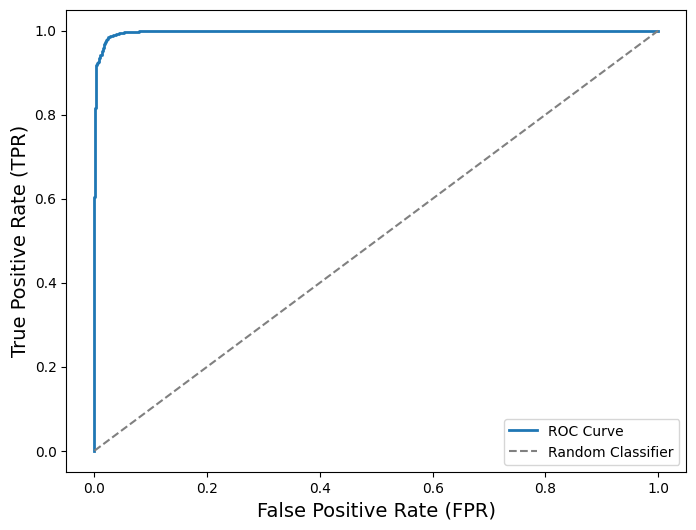

Threshold 0.35: F1 Score = 0.9780
Threshold 0.4: F1 Score = 0.9765
Threshold 0.45: F1 Score = 0.9762
Threshold 0.5: F1 Score = 0.9723


In [75]:
from sklearn.metrics import roc_curve, f1_score

# Define thresholds to evaluate
thresholds = [0.35, 0.4, 0.45, 0.5]

# Combine distances and labelss
all_distances = np.concatenate([same_distances, different_distances])
all_labels = np.concatenate([np.ones_like(same_distances), np.zeros_like(different_distances)])

# Compute ROC curve
fpr, tpr, roc_thresholds = roc_curve(all_labels, -all_distances)

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label="ROC Curve", linewidth=2)
plt.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Random Classifier")

# Mark selected thresholds on the ROC curve
for t in thresholds:
    if t in roc_thresholds:  # Ensure threshold exists in computed ROC thresholds
        idx = np.searchsorted(roc_thresholds[::-1], t, side="right")
        plt.scatter(fpr[::-1][idx], tpr[::-1][idx], marker="o", label=f"Threshold {t}")

plt.xlabel("False Positive Rate (FPR)", fontsize=14)
plt.ylabel("True Positive Rate (TPR)", fontsize=14)
# plt.title("ROC Curve with Selected Thresholds")
plt.legend()
plt.show()

# Compute F1 scores for selected thresholds
for t in thresholds:
    predictions = (all_distances < t).astype(int)
    f1 = f1_score(all_labels, predictions)
    print(f"Threshold {t}: F1 Score = {f1:.4f}")


In [44]:
from sklearn.metrics import confusion_matrix, classification_report

threshold = 0.45  # Adjust based on F1-score analysis

predictions = (all_distances < threshold).astype(int)

conf_matrix = confusion_matrix(all_labels, predictions)
tn, fp, fn, tp = conf_matrix.ravel()

# Print confusion matrix
print("Confusion Matrix:")
print(conf_matrix)
print(f"TN: {tn}, FP: {fp}, FN: {fn}, TP: {tp}")

# Print classification report (includes Precision, Recall, and F1 Score)
print("\nClassification Report:")
print(classification_report(all_labels, predictions, digits=4))

Confusion Matrix:
[[1162   53]
 [   6 1209]]
TN: 1162, FP: 53, FN: 6, TP: 1209

Classification Report:
              precision    recall  f1-score   support

         0.0     0.9949    0.9564    0.9752      1215
         1.0     0.9580    0.9951    0.9762      1215

    accuracy                         0.9757      2430
   macro avg     0.9764    0.9757    0.9757      2430
weighted avg     0.9764    0.9757    0.9757      2430



Trying out small Classifier instead of fixed threshold

In [45]:
# Logistic Regression Classifier

from sklearn.linear_model import LogisticRegression

# Prepare training data (distances as input, labels as output) from the validation set
X_classifier_train = np.concatenate([same_distances, different_distances]).reshape(-1, 1)
y_classifier_train = np.concatenate([np.ones_like(same_distances), np.zeros_like(different_distances)])

# Train logistic regression model
lr_classifier = LogisticRegression()
lr_classifier.fit(X_classifier_train, y_classifier_train)

print(f"Model Coefficients: {lr_classifier.coef_}, Intercept: {lr_classifier.intercept_}")


Model Coefficients: [[-9.67088739]], Intercept: [3.91688645]


In [46]:
# Evaluate the LR classifier on the test set

test_same_distances = []
test_different_distances = []

correct = 0
total = 0

# prepare distance test data from the test set
with torch.no_grad():
    for x1, x2, labels in test_loader:
        x1, x2, labels = x1.to(device), x2.to(device), labels.to(device)

        embed1 = spectrum_embedding(x1, cnn, lstm, fc)
        embed2 = spectrum_embedding(x2, cnn, lstm, fc)
        distances = F.pairwise_distance(embed1, embed2, p=2).cpu().numpy()

        for i, label in enumerate(labels.cpu().numpy()):
            if label == 1:
                test_same_distances.append(distances[i])
            else:
                test_different_distances.append(distances[i])

# Convert test distances into numpy arrays
X_classifier_test = np.concatenate([test_same_distances, test_different_distances]).reshape(-1, 1)
y_classifier_test = np.concatenate([np.ones_like(test_same_distances), np.zeros_like(test_different_distances)])

# Evaluate on distance test set
predictions_lr = lr_classifier.predict(X_classifier_test)

# Compute confusion matrix and classification report
from sklearn.metrics import classification_report, confusion_matrix

print("Confusion Matrix:")
print(confusion_matrix(y_classifier_test, predictions_lr))

print("\nClassification Report:")
print(classification_report(y_classifier_test, predictions_lr, digits=4))


Confusion Matrix:
[[1177   38]
 [   0 1215]]

Classification Report:
              precision    recall  f1-score   support

         0.0     1.0000    0.9687    0.9841      1215
         1.0     0.9697    1.0000    0.9846      1215

    accuracy                         0.9844      2430
   macro avg     0.9848    0.9844    0.9844      2430
weighted avg     0.9848    0.9844    0.9844      2430



In [47]:
# Neural Network Classifier

import torch.nn as nn
import torch.optim as optim

# Define a simple feedforward neural network
class DistanceClassifier(nn.Module):
    def __init__(self):
        super(DistanceClassifier, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(1, 8),
            nn.ReLU(),
            nn.Linear(8, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.fc(x)

# Initialize model, loss, and optimizer
mlp_classifier = DistanceClassifier().to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(mlp_classifier.parameters(), lr=0.01)

X_train_tensor = torch.tensor(X_classifier_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_classifier_train, dtype=torch.float32).unsqueeze(1).to(device)

# Train the classifier
for epoch in range(100):
    optimizer.zero_grad()
    outputs = mlp_classifier(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()

    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}")

# Save the classifier to use it in another python file
torch.save(mlp_classifier, 'distance_classifier_full.pth')

Epoch 0, Loss: 0.6607
Epoch 10, Loss: 0.5931
Epoch 20, Loss: 0.5196
Epoch 30, Loss: 0.4348
Epoch 40, Loss: 0.3442
Epoch 50, Loss: 0.2611
Epoch 60, Loss: 0.1961
Epoch 70, Loss: 0.1527
Epoch 80, Loss: 0.1241
Epoch 90, Loss: 0.1064


In [48]:
# Find the best probability threshold for the NN classifier based on best f1  score

from sklearn.metrics import f1_score, roc_curve

# Compute probabilities
X_test_tensor = torch.tensor(X_classifier_test, dtype=torch.float32).to(device)
with torch.no_grad():
    probabilities = mlp_classifier(X_test_tensor).cpu().numpy().flatten()

# Compute ROC curve to get thresholds
fpr, tpr, thresholds = roc_curve(y_classifier_test, probabilities)

# Find the best threshold based on F1-score
best_threshold = 0
best_f1 = 0

for t in thresholds:
    preds = (probabilities > t).astype(int)
    f1 = f1_score(y_classifier_test, preds)
    if f1 > best_f1:
        best_f1 = f1
        best_threshold = t

print(f"Best Threshold: {best_threshold:.4f} with F1 Score: {best_f1:.4f}")


Best Threshold: 0.7637 with F1 Score: 0.9906


In [49]:
# Evaluate the NN classifier on the test set

# Predict using the neural network
with torch.no_grad():
    predictions_nn = (probabilities > 0.8163).astype(int)

# Compute evaluation metrics
print("Confusion Matrix:")
print(confusion_matrix(y_classifier_test, predictions_nn))

print("\nClassification Report:")
print(classification_report(y_classifier_test, predictions_nn, digits=4))


Confusion Matrix:
[[1205   10]
 [  15 1200]]

Classification Report:
              precision    recall  f1-score   support

         0.0     0.9877    0.9918    0.9897      1215
         1.0     0.9917    0.9877    0.9897      1215

    accuracy                         0.9897      2430
   macro avg     0.9897    0.9897    0.9897      2430
weighted avg     0.9897    0.9897    0.9897      2430



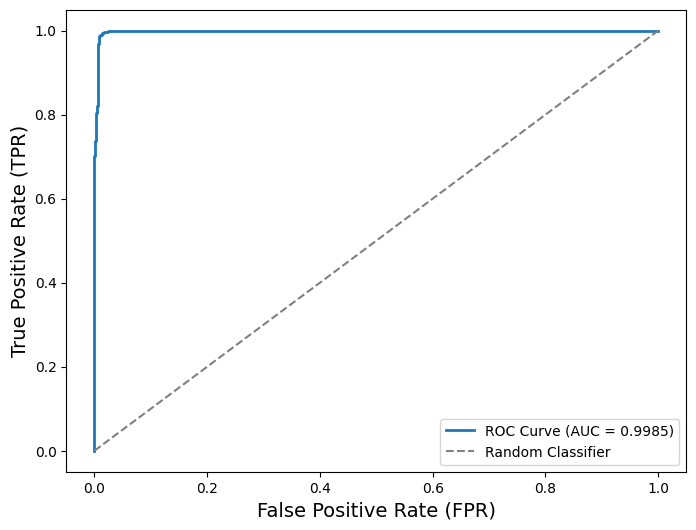

In [73]:
from sklearn.metrics import roc_curve, roc_auc_score

# Compute ROC curve
fpr, tpr, _ = roc_curve(y_classifier_test, (mlp_classifier(torch.tensor(X_classifier_test, dtype=torch.float32).to(device)) ).cpu().detach().numpy())

# Compute AUC score
auc_score = roc_auc_score(y_classifier_test, mlp_classifier(torch.tensor(X_classifier_test, dtype=torch.float32)).cpu().detach().numpy())

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {auc_score:.4f})", linewidth=2)
plt.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Random Classifier")
plt.xlabel("False Positive Rate (FPR)", fontsize=14)
plt.ylabel("True Positive Rate (TPR)", fontsize=14)
# plt.title("ROC Curve")
plt.legend()
plt.show()


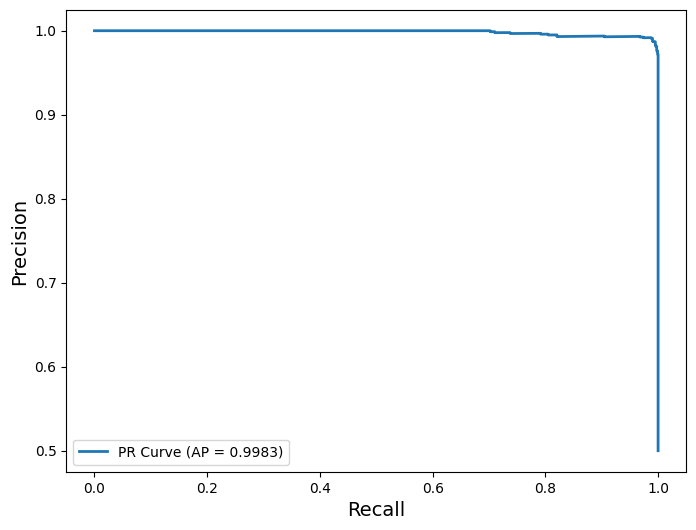

In [74]:
from sklearn.metrics import precision_recall_curve, average_precision_score

# Compute Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_classifier_test, mlp_classifier(torch.tensor(X_classifier_test, dtype=torch.float32).to(device)).cpu().detach().numpy())

# Compute Average Precision Score
ap_score = average_precision_score(y_classifier_test, mlp_classifier(torch.tensor(X_classifier_test, dtype=torch.float32)).cpu().detach().numpy())

# Plot Precision-Recall Curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f"PR Curve (AP = {ap_score:.4f})", linewidth=2)
plt.xlabel("Recall", fontsize=14)
plt.ylabel("Precision", fontsize=14)
# plt.title("Precision-Recall Curve")
plt.legend()
plt.show()


Compound family classifier on raw data

In [52]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from sklearn.manifold import TSNE

# Define drug family labels
folder_labels = {
    "CM1": "Synthetic Opioid",        # Fentanyl & Analogs
    "CM2": "Cathinone (Stimulant)",    # "Bath Salts"
    "CM3": "Synthetic Cannabinoid"     # THC-like compounds
}

# Convert dataset dictionary to DataFrame
data_list = []
for folder, label in folder_labels.items():
    for file_name, features in binned_df.iterrows():
        if file_name.startswith(folder):  # Ensure correct mapping
            data_list.append([file_name, label] + features.tolist())

# Create DataFrame
columns = ["File", "Class"] + list(binned_df.columns)
df = pd.DataFrame(data_list, columns=columns)

# Encode class labels
label_encoder = LabelEncoder()
df["Class_Encoded"] = label_encoder.fit_transform(df["Class"])

In [53]:
# Ensure all column names are strings
df.columns = df.columns.astype(str)

# Check the first few rows to confirm the structure
df.head()
print()


In [54]:

# Drop non-numeric columns ("File" and "Class") and select only numerical features
X = df.drop(columns=["File", "Class"]).select_dtypes(include=[np.number])

# Ensure all column names are strings
X.columns = X.columns.astype(str)

# Target variable (encoded class labels)
y = df["Class_Encoded"]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Train Random Forest classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Make predictions
y_pred = clf.predict(X_test)


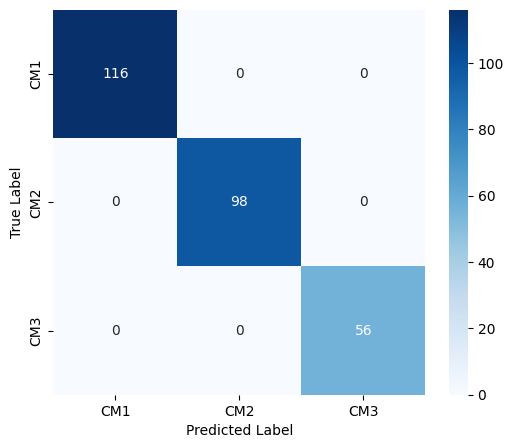

In [76]:
# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
# plt.title("Confusion Matrix")
plt.show()

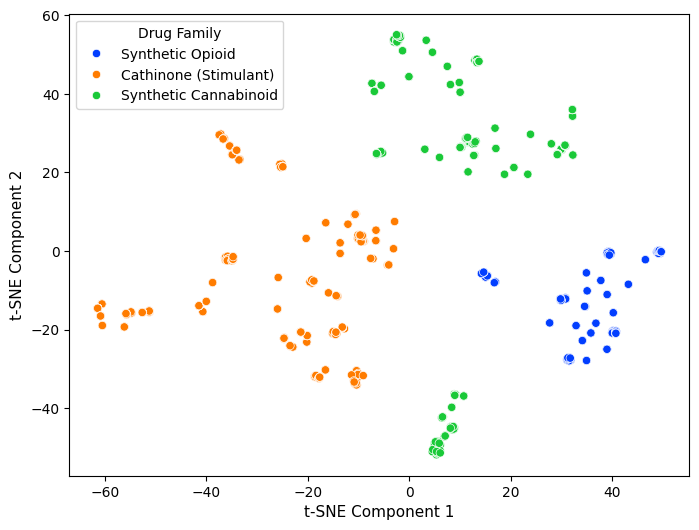

In [79]:
# Reduce features to 2D using t-SNE
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X)

# Plot the transformed features
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=df["Class"], palette="bright")
# plt.title("t-SNE Visualization of Drug Families from Raw Spectra")
plt.xlabel("t-SNE Component 1", fontsize=11)
plt.ylabel("t-SNE Component 2", fontsize=11)
plt.legend(title="Drug Family")
plt.show()

Compound family classifier using the embedded vectors

In [57]:

# Create a function to extract the compound identifier
def get_compound_family(idx):
    return idx.rsplit('_', 1)[0]

# Used compound shuffled df 
shuffled_df_tensor = torch.tensor(shuffled_df.values, dtype=torch.float32).to(device)

with torch.no_grad():
    compound_embeddings = spectrum_embedding(shuffled_df_tensor, cnn, lstm, fc).cpu().numpy()

df_embeddings = pd.DataFrame(compound_embeddings)
df_embeddings['Family'] = [get_compound_family(idx) for idx in shuffled_df.index]


In [58]:
# Dimensionality Reduction on Compound Embeddings

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap

# Apply PCA
pca = PCA(n_components=2)
pca_embeddings = pca.fit_transform(compound_embeddings)

# Apply t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
tsne_embeddings = tsne.fit_transform(compound_embeddings)

# Apply UMAP
umap_model = umap.UMAP(n_components=2, random_state=42)
umap_embeddings = umap_model.fit_transform(compound_embeddings)

# Store reduced embeddings
df_embeddings["PCA1"], df_embeddings["PCA2"] = pca_embeddings[:, 0], pca_embeddings[:, 1]
df_embeddings["tSNE1"], df_embeddings["tSNE2"] = tsne_embeddings[:, 0], tsne_embeddings[:, 1]
df_embeddings["UMAP1"], df_embeddings["UMAP2"] = umap_embeddings[:, 0], umap_embeddings[:, 1]


/Users/dalonsobc/Documents/Estudio/Trent/Winter 2025/AMOD-5610 Major Research Paper/Mass Spectra Siamese Network/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/dalonsobc/Documents/Estudio/Trent/Winter 2025/AMOD-5610 Major Research Paper/Mass Spectra Siamese Network/venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/dalonsobc/Documents/Estudio/Trent/Winter 2025/AMOD-5610 Major Research Paper/Mass Spectra Siamese Network/venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max

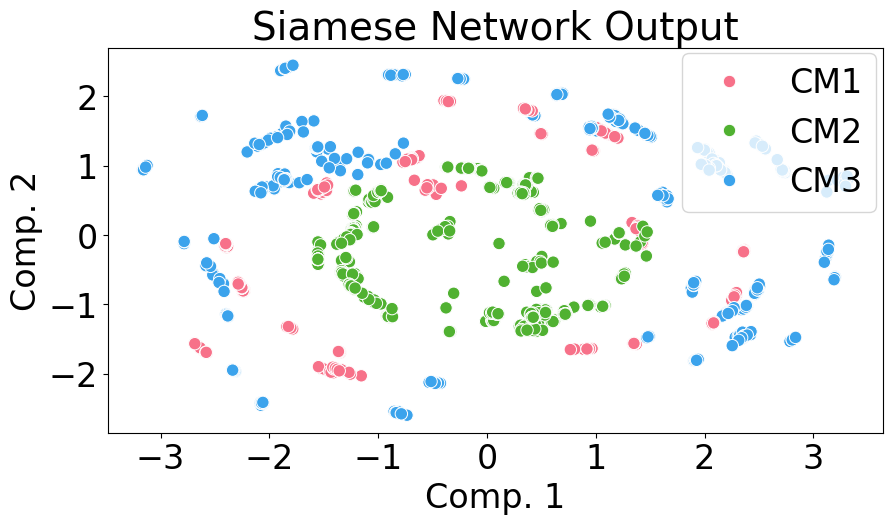

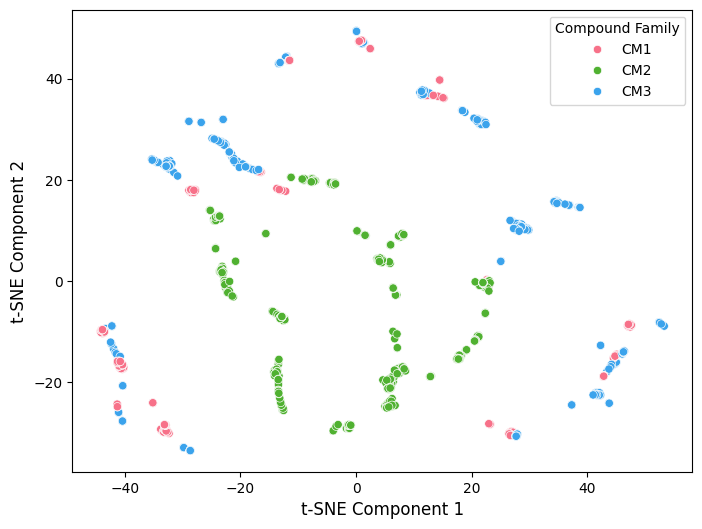

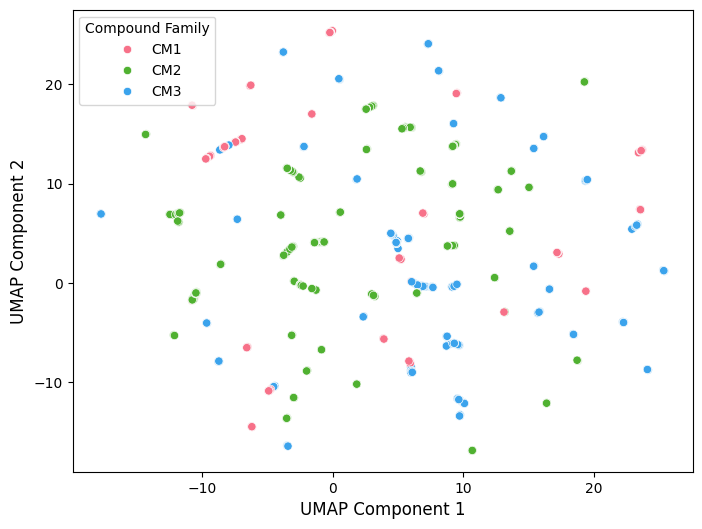

In [103]:
# Plot the reduced embeddings in a compound family map

import seaborn as sns

# Set color palette for families
family_palette = sns.color_palette("husl", len(df_embeddings["Family"].unique()))

# PCA Plot
plt.figure(figsize=(10, 5))
sns.scatterplot(x="PCA1", y="PCA2", hue="Family", data=df_embeddings, palette=family_palette, s=80)
plt.title("Siamese Network Output", fontsize=28)
plt.xlabel("Comp. 1", fontsize=24)
plt.ylabel("Comp. 2", fontsize=24)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.legend(bbox_to_anchor=(0.72, 0.53), fontsize=24)
plt.show()

# t-SNE Plot
plt.figure(figsize=(8, 6))
sns.scatterplot(x="tSNE1", y="tSNE2", hue="Family", data=df_embeddings, palette=family_palette)
# plt.title("Family Map - t-SNE")
plt.xlabel("t-SNE Component 1", fontsize=12)
plt.ylabel("t-SNE Component 2", fontsize=12)
plt.legend(title="Compound Family")
plt.show()

# Plot UMAP
plt.figure(figsize=(8, 6))
sns.scatterplot(x="UMAP1", y="UMAP2", hue="Family", data=df_embeddings, palette="husl")
# plt.title("Family Map - UMAP")
plt.xlabel("UMAP Component 1", fontsize=12)
plt.ylabel("UMAP Component 2", fontsize=12)
plt.legend(title="Compound Family")
plt.show()



In [60]:
# Train a family classification model on the full compound embeddings

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Use the full embeddings instead of the projected ones
X_fcm = compound_embeddings 

# Encode categorical family labels into numerical values
label_encoder = LabelEncoder()
y_fcm = label_encoder.fit_transform(df_embeddings["Family"])  # Converts 'CM1', 'CM2', 'CM3', etc. into 0,1,2...

# Split into training (80%) and testing (20%) sets
X_train_fcm, X_test_fcm, y_train_fcm, y_test_fcm = train_test_split(X_fcm, y_fcm, test_size=0.2, random_state=42, stratify=y_fcm)

print(f"Training samples: {len(X_train_fcm)}, Test samples: {len(X_test_fcm)}")

Training samples: 1080, Test samples: 270


In [61]:
from sklearn.ensemble import RandomForestClassifier

clf_fcm = RandomForestClassifier(n_estimators=100, random_state=42)
clf_fcm.fit(X_train_fcm, y_train_fcm)

y_pred_fcm = clf_fcm.predict(X_test_fcm)


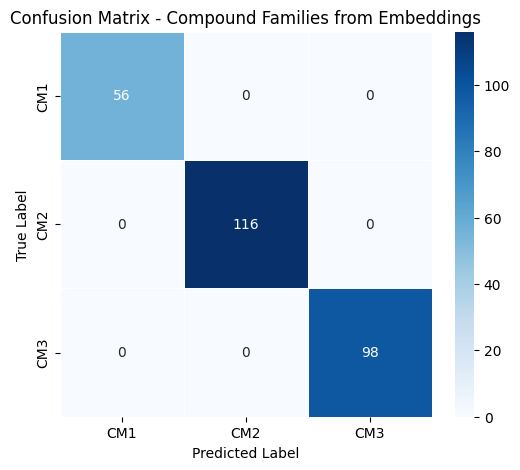


Classification Report:
               precision    recall  f1-score   support

         CM1       1.00      1.00      1.00        56
         CM2       1.00      1.00      1.00       116
         CM3       1.00      1.00      1.00        98

    accuracy                           1.00       270
   macro avg       1.00      1.00      1.00       270
weighted avg       1.00      1.00      1.00       270



In [62]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Compute Confusion Matrix
cm_fcm = confusion_matrix(y_test_fcm, y_pred_fcm)

# Convert to DataFrame for labeling
cm_fcm_df = pd.DataFrame(cm_fcm, index=label_encoder.classes_, columns=label_encoder.classes_)

# Plot Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm_fcm_df, annot=True, fmt="d", cmap="Blues", linewidths=0.5)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - Compound Families from Embeddings")
plt.show()

# Print classification report
print("\nClassification Report:\n", classification_report(y_test_fcm, y_pred_fcm, target_names=label_encoder.classes_))
